In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [99]:
import requests
import pandas as pd
from time import sleep

def get_weather_data(city, lat, lon, start='20150101', end='20241231'):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M,T2M_MAX,T2M_MIN,PRECTOT,RH2M,WS2M,ALLSKY_SFC_SW_DWN",
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start,
        "end": end,
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    
    try:
        data = response.json()
        if 'properties' not in data:
            print(f"⚠️ API error for {city}: {data}")
            return pd.DataFrame()  # Return empty DataFrame on error

        parameters = data['properties']['parameter']
        df = pd.DataFrame(parameters)
        df.index.name = 'Date'
        df.index = pd.to_datetime(df.index)
        df['City'] = city
        return df

    except Exception as e:
        print(f"❌ Failed to parse data for {city}: {e}")
        return pd.DataFrame()


# Define cities and coordinates
cities = {
    "Abuja": (9.0579, 7.4951),
    "Ilorin": (8.4966, 4.5421),
    "Maiduguri": (11.8311, 13.1500),
    "Yola": (9.2035, 12.4954),
    "Kano": (12.0022, 8.5919),
    "Sokoto": (13.0059, 5.2476),
    "Enugu": (6.5244, 7.5189),
    "Owerri": (5.4836, 7.0330),
    "Port Harcourt": (4.8156, 7.0498),
    "Calabar": (4.9589, 8.3269),
    "Lagos": (6.5244, 3.3792),
    "Ibadan": (7.3775, 3.9470)
}

# Fetch and save data
all_data = []
for city, (lat, lon) in cities.items():
    print(f"Fetching data for {city}...")
    df = get_weather_data(city, lat, lon)
    df.to_csv(f"{city}_weather_2015_2024.csv")
    all_data.append(df)
    sleep(1)  # Be kind to the API

# Combine all into one DataFrame
combined_df = pd.concat(all_data)
combined_df.to_csv("Nigeria_Weather_2015_2024_All_Cities.csv")

Fetching data for Abuja...
Fetching data for Ilorin...
Fetching data for Maiduguri...
Fetching data for Yola...
Fetching data for Kano...
Fetching data for Sokoto...
Fetching data for Enugu...
Fetching data for Owerri...
Fetching data for Port Harcourt...
Fetching data for Calabar...
Fetching data for Lagos...
Fetching data for Ibadan...


In [100]:
combined_df.head()

,T2M_MIN,T2M_MAX,T2M,RH2M,ALLSKY_SFC_SW_DWN,WS2M,PRECTOTCORR,City
Date,,,,,,,,
2015-01-01,17.07,34.50,25.07,32.32,5.57,2.12,0.0,Abuja
2015-01-02,16.15,34.91,24.43,29.53,5.87,2.46,0.0,Abuja
2015-01-03,16.26,35.13,24.22,25.65,5.63,3.64,0.0,Abuja
2015-01-04,15.36,34.51,23.51,24.25,5.64,3.78,0.0,Abuja
2015-01-05,15.20,33.12,23.01,27.83,4.80,2.46,0.0,Abuja


In [101]:
combined_df.shape

(43836, 8)

In [102]:
import pandas as pd
import numpy as np

# Assume your DataFrame is called df and has a 'Solar_Radiation' column
sr = df['ALLSKY_SFC_SW_DWN'].copy()

# Find indices where the value is -999
bad_indices = sr[sr == -999].index

# Replace each -999 with the average of its nearest non-bad neighbors
for idx in bad_indices:
    prev_idx = idx - 1
    next_idx = idx + 1

    # Find previous valid value
    while prev_idx in bad_indices and prev_idx >= 0:
        prev_idx -= 1
    prev_val = sr[prev_idx] if prev_idx >= 0 else np.nan

    # Find next valid value
    while next_idx in bad_indices and next_idx < len(sr):
        next_idx += 1
    next_val = sr[next_idx] if next_idx < len(sr) else np.nan

    # Compute mean of valid neighbors
    valid_neighbors = [v for v in [prev_val, next_val] if not pd.isna(v)]
    sr[idx] = np.mean(valid_neighbors) if valid_neighbors else np.nan

# Assign cleaned series back to DataFrame
df['ALLSKY_SFC_SW_DWN'] = sr

In [103]:
column_mapping = {
    "ALLSKY_SFC_SW_DWN": "Solar_Radiation (W/m²)",
    "T2M_MAX": "Max_Temperature (°C)",
    "T2M_MIN": "Min_Temperature (°C)",
    "T2M": "Avg_Temperature (°C)",
    "WS2M": "Wind_Speed_2m (m/s)",
    "RH2M": "Relative_Humidity_2m (%)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "City": "City"
}
combined_df.rename(columns=column_mapping, inplace=True)

In [104]:
zone_mapping = {
    "Abuja": "North Central",
    "Ilorin": "North Central",
    "Maiduguri": "North East",
    "Yola": "North East",
    "Kano": "North West",
    "Sokoto": "North West",
    "Enugu": "South East",
    "Owerri": "South East",
    "Port Harcourt": "South South",
    "Calabar": "South South",
    "Lagos": "South West",
    "Ibadan": "South West"
}
combined_df["Geopolitical Zone"] = combined_df["City"].map(zone_mapping)
combined_df.head()

,Min_Temperature (°C),Max_Temperature (°C),Avg_Temperature (°C),Relative_Humidity_2m (%),Solar_Radiation (W/m²),Wind_Speed_2m (m/s),Precipitation (mm/day),City,Geopolitical Zone
Date,,,,,,,,,
2015-01-01,17.07,34.50,25.07,32.32,5.57,2.12,0.0,Abuja,North Central
2015-01-02,16.15,34.91,24.43,29.53,5.87,2.46,0.0,Abuja,North Central
2015-01-03,16.26,35.13,24.22,25.65,5.63,3.64,0.0,Abuja,North Central
2015-01-04,15.36,34.51,23.51,24.25,5.64,3.78,0.0,Abuja,North Central
2015-01-05,15.20,33.12,23.01,27.83,4.80,2.46,0.0,Abuja,North Central


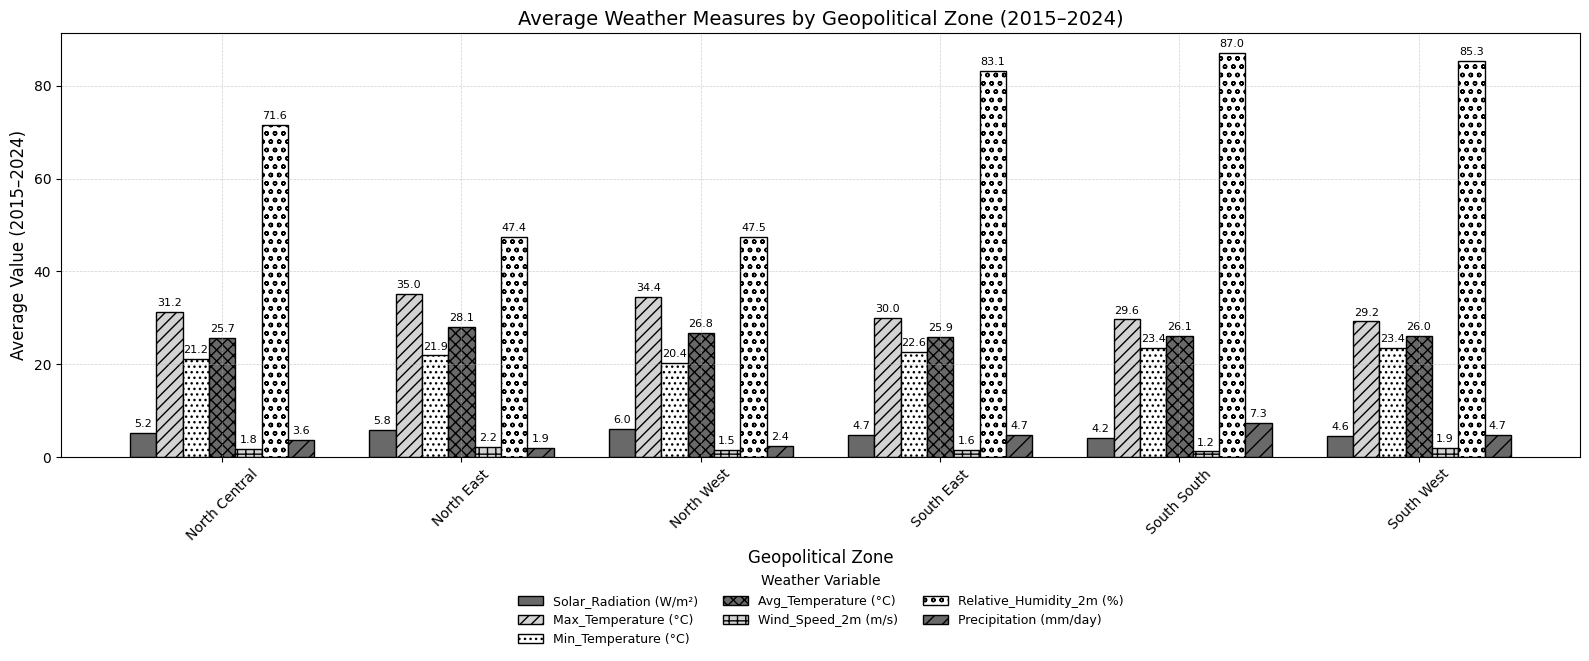

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Weather variables to plot
weather_vars = [
    "Solar_Radiation (W/m²)",
    "Max_Temperature (°C)",
    "Min_Temperature (°C)",
    "Avg_Temperature (°C)",
    "Wind_Speed_2m (m/s)",
    "Relative_Humidity_2m (%)",
    "Precipitation (mm/day)"
]

# Group by Geopolitical Zone
zone_means = combined_df.groupby("Geopolitical Zone")[weather_vars].mean()
zones = zone_means.index.tolist()
x = np.arange(len(zones))
width = 0.11

# Define alternating styles (black, gray, white with hatching)
styles = [
    {'color': 'dimgray', 'hatch': ''},
    {'color': 'lightgray', 'hatch': '///'},
    {'color': 'white', 'hatch': '...'},
    {'color': 'dimgray', 'hatch': 'xxx'},
    {'color': 'lightgray', 'hatch': '++'},
    {'color': 'white', 'hatch': 'oo'},
    {'color': 'dimgray', 'hatch': '//'}
]

fig, ax = plt.subplots(figsize=(16, 7))

# Plot each variable with alternating styles
for i, var in enumerate(weather_vars):
    style = styles[i % len(styles)]
    bars = ax.bar(x + i * width, zone_means[var], width,
                  label=var,
                  color=style['color'],
                  hatch=style['hatch'],
                  edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Formatting
ax.set_xlabel("Geopolitical Zone", fontsize=12)
ax.set_ylabel("Average Value (2015–2024)", fontsize=12)
ax.set_title("Average Weather Measures by Geopolitical Zone (2015–2024)", fontsize=14)
ax.set_xticks(x + width * (len(weather_vars) - 1) / 2)
ax.set_xticklabels(zones, rotation=45)
ax.legend(
    title="Weather Variable",
    fontsize=9,
    title_fontsize=10,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),  # moved further down
    ncol=3,
    frameon=False
)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

In [106]:
zone_means.round(2)

,Solar_Radiation (W/m²),Max_Temperature (°C),Min_Temperature (°C),Avg_Temperature (°C),Wind_Speed_2m (m/s),Relative_Humidity_2m (%),Precipitation (mm/day)
Geopolitical Zone,,,,,,,
North Central,5.15,31.24,21.17,25.69,1.76,71.63,3.62
North East,5.80,35.04,21.88,28.07,2.21,47.35,1.94
North West,5.95,34.39,20.36,26.77,1.52,47.46,2.42
South East,4.66,29.99,22.56,25.90,1.55,83.09,4.73
South South,4.19,29.63,23.44,26.14,1.19,86.99,7.27
South West,4.63,29.21,23.40,25.99,1.86,85.25,4.73


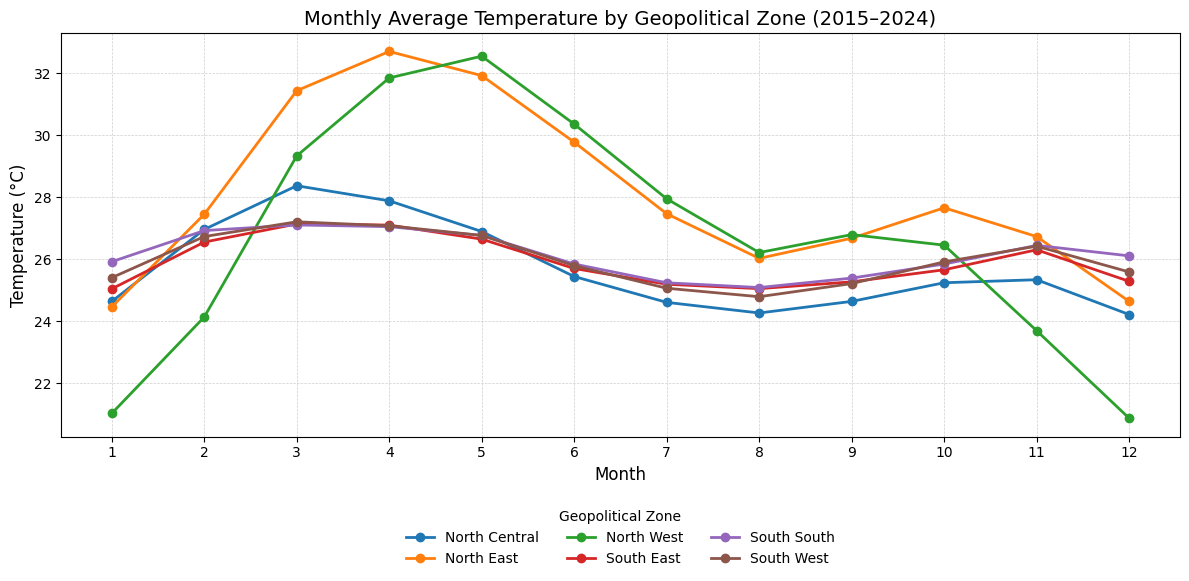

In [107]:
import matplotlib.pyplot as plt

# Ensure 'Month' column exists
combined_df['Month'] = combined_df.index.month

# Group by Month and Geopolitical Zone
monthly_zone_avg = combined_df.groupby(['Month', 'Geopolitical Zone'])[
    "Avg_Temperature (°C)"
].mean().reset_index()

# Pivot temperature data
temp_data = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Avg_Temperature (°C)')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10.colors

for i, zone in enumerate(temp_data.columns):
    ax.plot(temp_data.index, temp_data[zone], label=zone, color=colors[i], marker='o', linewidth=2)

ax.set_title("Monthly Average Temperature by Geopolitical Zone (2015–2024)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.set_xticks(range(1, 13))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.legend(title="Geopolitical Zone", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.tight_layout()
plt.show()


In [108]:
monthly_temp_table = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Avg_Temperature (°C)')
monthly_temp_table.round(2)

Geopolitical Zone,North Central,North East,North West,South East,South South,South West
Month,,,,,,
1,24.64,24.46,21.02,25.04,25.92,25.40
2,26.96,27.45,24.13,26.55,26.92,26.73
3,28.37,31.44,29.33,27.14,27.10,27.21
4,27.88,32.70,31.85,27.10,27.05,27.08
5,26.89,31.92,32.55,26.65,26.76,26.77
6,25.44,29.77,30.36,25.70,25.84,25.79
7,24.60,27.46,27.95,25.19,25.24,25.06
8,24.26,26.03,26.21,25.05,25.08,24.79
9,24.64,26.68,26.79,25.27,25.39,25.21


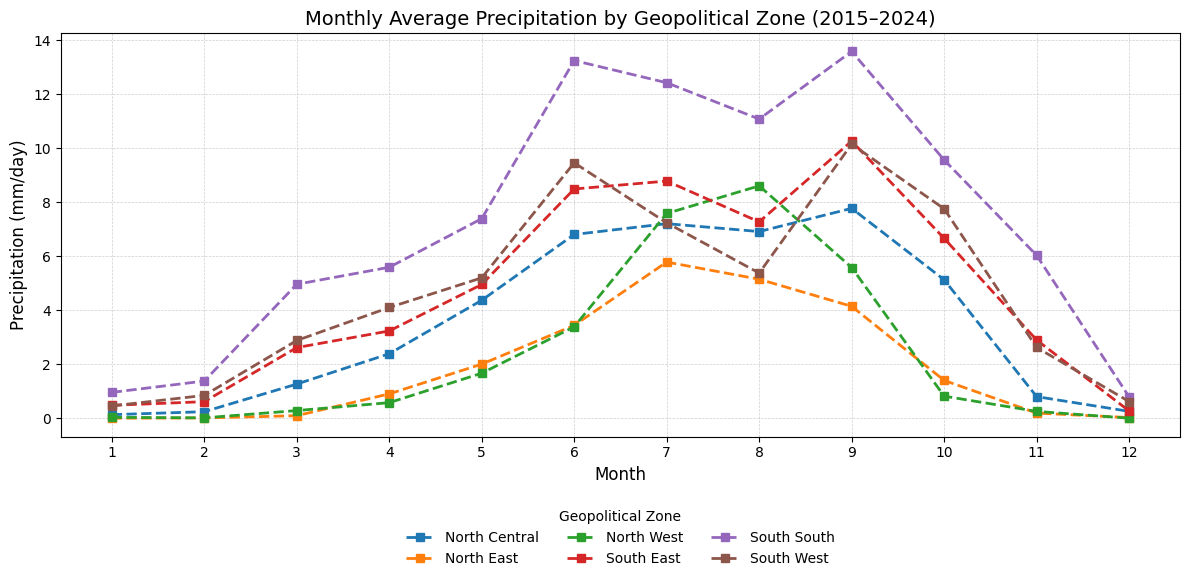

In [109]:
# Ensure 'Month' column exists
combined_df['Month'] = combined_df.index.month

# Group by Month and Geopolitical Zone for multiple variables
monthly_zone_avg = combined_df.groupby(['Month', 'Geopolitical Zone'])[
    [
        "Avg_Temperature (°C)",
        "Precipitation (mm/day)"
    ]
].mean().reset_index()


# Pivot precipitation data
rain_data = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Precipitation (mm/day)')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, zone in enumerate(rain_data.columns):
    ax.plot(rain_data.index, rain_data[zone], label=zone, color=colors[i], linestyle='--', marker='s', linewidth=2)

ax.set_title("Monthly Average Precipitation by Geopolitical Zone (2015–2024)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Precipitation (mm/day)", fontsize=12)
ax.set_xticks(range(1, 13))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.legend(title="Geopolitical Zone", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.tight_layout()
plt.show()


In [110]:
monthly_rain_table = monthly_zone_avg.reset_index().pivot(index='Month', columns='Geopolitical Zone', values='Precipitation (mm/day)')
monthly_rain_table.round(2)

Geopolitical Zone,North Central,North East,North West,South East,South South,South West
Month,,,,,,
1,0.13,0.00,0.03,0.48,0.96,0.46
2,0.24,0.01,0.01,0.61,1.38,0.84
3,1.26,0.09,0.28,2.62,4.96,2.88
4,2.39,0.90,0.58,3.23,5.59,4.10
5,4.37,2.00,1.67,4.95,7.39,5.20
6,6.81,3.44,3.39,8.49,13.25,9.46
7,7.21,5.78,7.59,8.79,12.43,7.24
8,6.92,5.15,8.61,7.27,11.08,5.38
9,7.77,4.14,5.58,10.27,13.59,10.15


In [121]:
combined_df.drop(columns='Month').describe().round(2)

,Min_Temperature (°C),Max_Temperature (°C),Avg_Temperature (°C),Relative_Humidity_2m (%),Solar_Radiation (W/m²),Wind_Speed_2m (m/s),Precipitation (mm/day),Year
count,43836.00,43836.00,43836.00,43836.00,43836.00,43836.00,43836.00,43836.00
mean,22.13,31.58,26.43,70.30,5.06,1.68,4.12,2019.50
std,3.28,3.79,2.65,24.02,1.22,0.79,9.10,2.87
min,5.88,18.83,13.18,3.89,0.48,0.10,0.00,2015.00
25%,21.31,28.95,25.05,57.44,4.36,1.11,0.00,2017.00
50%,22.86,30.55,26.15,82.08,5.23,1.54,0.93,2020.00
75%,24.03,33.29,27.39,88.17,5.95,2.11,4.58,2022.00
max,32.30,45.56,38.49,96.53,8.20,5.78,287.97,2024.00


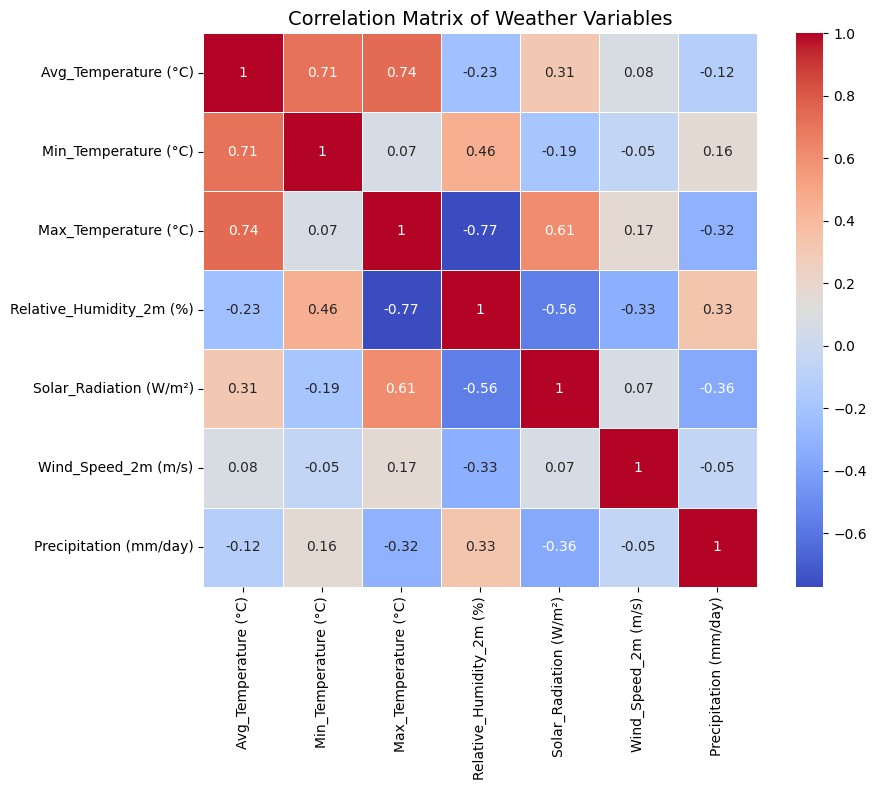

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric weather columns
weather_vars = [
    "Avg_Temperature (°C)",
    "Min_Temperature (°C)",
    "Max_Temperature (°C)",
    "Relative_Humidity_2m (%)",
    "Solar_Radiation (W/m²)",
    "Wind_Speed_2m (m/s)",
    "Precipitation (mm/day)"
]

# Compute correlation matrix
corr_matrix = combined_df[weather_vars].corr().round(2)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True)
plt.title("Correlation Matrix of Weather Variables", fontsize=14)
plt.tight_layout()
plt.show()

In [114]:
# Step 1: Add 'Month' and 'Season'
combined_df['Month'] = combined_df.index.month
combined_df['Season'] = combined_df['Month'].apply(lambda m: 'Dry' if m in [11, 12, 1, 2, 3] else 'Rainy')

# Step 2: Compute seasonal averages and round to 2 decimal places
seasonal_avg = combined_df.groupby(['Geopolitical Zone', 'Season'])[
    [
        "Avg_Temperature (°C)",
        "Min_Temperature (°C)",
        "Max_Temperature (°C)",
        "Relative_Humidity_2m (%)",
        "Solar_Radiation (W/m²)",
        "Wind_Speed_2m (m/s)",
        "Precipitation (mm/day)"
    ]
].mean().round(2)

# Step 3: Define highlighting function
def highlight_extremes(df):
    def style_column(s):
        is_max = s == s.max()
        is_min = s == s.min()
        return ['color: red' if v else 'color: blue' if w else '' for v, w in zip(is_max, is_min)]
    
    return df.style.apply(style_column, subset=df.columns, axis=0).format("{:.2f}")

# Step 4: Display styled and rounded table
highlight_extremes(seasonal_avg)

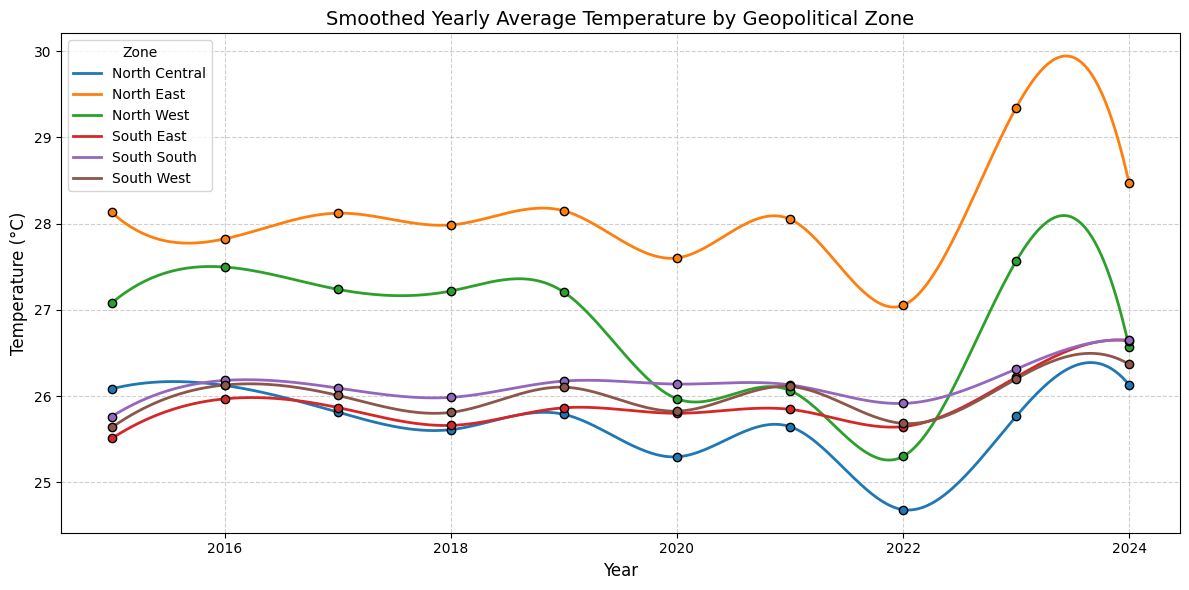

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Ensure 'Year' column exists
combined_df['Year'] = combined_df.index.year

# Group by Year and Geopolitical Zone
yearly_avg = combined_df.groupby(['Year', 'Geopolitical Zone'])[
    "Avg_Temperature (°C)"
].mean().reset_index()



fig, ax = plt.subplots(figsize=(12, 6))

for zone in yearly_avg['Geopolitical Zone'].unique():
    zone_data = yearly_avg[yearly_avg['Geopolitical Zone'] == zone]
    x = zone_data['Year']
    y = zone_data["Avg_Temperature (°C)"]

    # Smooth curve
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)

    # Plot smooth line
    ax.plot(x_smooth, y_smooth, label=zone, linewidth=2)

    # Plot original data points
    ax.scatter(x, y, color=ax.lines[-1].get_color(), edgecolor='black', zorder=5)

ax.set_title("Smoothed Yearly Average Temperature by Geopolitical Zone", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="Zone", loc='upper left')
plt.tight_layout()
plt.show()

In [116]:
import numpy as np

def create_multistep_dataset(df, input_days=30, forecast_days=7):
    """
    Converts time series into supervised learning format for multi-output forecasting.
    
    Parameters:
        df (pd.DataFrame): Time-indexed weather data
        input_days (int): Number of past days to use as input
        forecast_days (int): Number of future days to predict
    
    Returns:
        X (np.array): Input features (samples, input_days, features)
        y (np.array): Output targets (samples, forecast_days, features)
    """
    X, y = [], []
    for i in range(len(df) - input_days - forecast_days + 1):
        X.append(df.iloc[i:i+input_days].values)
        y.append(df.iloc[i+input_days:i+input_days+forecast_days].values)
    return np.array(X), np.array(y)

In [117]:
# Select only numeric weather columns
weather_cols = [
    "Avg_Temperature (°C)",
    "Min_Temperature (°C)",
    "Max_Temperature (°C)",
    "Relative_Humidity_2m (%)",
    "Solar_Radiation (W/m²)",
    "Wind_Speed_2m (m/s)",
    "Precipitation (mm/day)"
]

# Filter for one city or zone for now (e.g., Abuja)
df_zone = combined_df[combined_df['City'] == 'Abuja'][weather_cols].dropna().sort_index()

# Create supervised dataset
X, y = create_multistep_dataset(df_zone, input_days=30, forecast_days=7)

print("Input shape:", X.shape)  # (samples, 30, features)
print("Target shape:", y.shape)  # (samples, 7, features)

Input shape: (3617, 30, 7)
Target shape: (3617, 7, 7)


In [118]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm shapes
print("X_train:", X_train.shape)  # (samples, 30, features)
print("y_train:", y_train.shape)  # (samples, 7, features)

X_train: (2893, 30, 7)
y_train: (2893, 7, 7)


In [119]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

n_timesteps = X_train.shape[1]      # 30
n_features = X_train.shape[2]       # 7
n_outputs = y_train.shape[1]        # 7

model = Sequential([
    LSTM(128, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(n_outputs * n_features),
    tf.keras.layers.Reshape((n_outputs, n_features))  # Output shape: (7, 7)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 128)             │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 49)                  │           3,185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 7, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,225 (477.44 KB)

 Trainable params: 122,225 (477.44 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 12358.0361 - mae: 81.6586 - val_loss: 10861.5938 - val_mae: 81.2858
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11122.2607 - mae: 77.7416 - val_loss: 2757.6707 - val_mae: 41.2863
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1929.0604 - mae: 33.4696 - val_loss: 601.0013 - val_mae: 17.7895
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 697.3422 - mae: 16.7224 - val_loss: 4579.5317 - val_mae: 49.9283
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1732.4690 - mae: 28.7532 - val_loss: 190.7270 - val_mae: 9.6079
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 160.2836 - mae: 8.6359 - val_loss: 202.9954 - val_mae: 10.7731
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2083.0337 - mae: 18.5233 - val_loss: 389.2289 - val_mae: 14.5352
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 209.8548 - mae: 10.2451 - val_loss: 89.5229 - val_mae: 6.1574
Epoch 9/30
73/73

In [122]:
loss, mae = model.evaluate(X_test, y_test)
print(f"LSTM Test Loss (MSE): {loss:.4f}")
print(f"LSTM Test MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 45.2767 - mae: 4.3188
LSTM Test Loss (MSE): 44.2650
LSTM Test MAE: 4.2448


In [123]:
!pip install keras-tcn --quiet

In [124]:
from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

n_timesteps = X_train.shape[1]      # 30
n_features = X_train.shape[2]       # 7
n_outputs = y_train.shape[1]        # 7

model_tcn = Sequential([
    TCN(input_shape=(n_timesteps, n_features), nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8]),
    Dense(n_outputs * n_features),
    tf.keras.layers.Reshape((n_outputs, n_features))
])

model_tcn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model_tcn.summary()

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tcn_2 (TCN)                          │ (None, 64)                  │          88,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 49)                  │           3,185 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 7, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,569 (357.69 KB)

 Trainable params: 91,569 (357.69 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
history_tcn = model_tcn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 8187.8555 - mae: 42.8500 - val_loss: 60.9048 - val_mae: 5.7475
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 58.2940 - mae: 5.5494 - val_loss: 43.7357 - val_mae: 4.7957
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 43.2653 - mae: 4.6673 - val_loss: 33.4070 - val_mae: 4.0724
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33.7621 - mae: 4.0100 - val_loss: 26.6388 - val_mae: 3.5505
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.8990 - mae: 3.5198 - val_loss: 23.7138 - val_mae: 3.2811
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.7226 - mae: 3.2315 - val_loss: 21.9434 - val_mae: 3.0907
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.1079 - mae: 3.0922 - val_loss: 20.4926 - val_mae: 2.9309
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.7649 - mae: 2.9624 - val_loss: 20.1089 - val_mae: 2.8689
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

In [126]:
loss_tcn, mae_tcn = model_tcn.evaluate(X_test, y_test)
print(f"TCN Test Loss (MSE): {loss_tcn:.4f}")
print(f"TCN Test MAE: {mae_tcn:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 19.1176 - mae: 2.3704
TCN Test Loss (MSE): 18.4928
TCN Test MAE: 2.3236


In [127]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add
from tensorflow.keras.models import Model

def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout)(ff)
    ff = Add()([attention, ff])
    return LayerNormalization(epsilon=1e-6)(ff)

def build_transformer_model(input_shape, output_shape, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)
    x = transformer_block(inputs, num_heads, ff_dim)
    x = transformer_block(x, num_heads, ff_dim)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(np.prod(output_shape))(x)
    outputs = tf.keras.layers.Reshape(output_shape)(x)
    return Model(inputs, outputs)

# Define shapes
input_shape = (X_train.shape[1], X_train.shape[2])   # (30, 7)
output_shape = (y_train.shape[1], y_train.shape[2])  # (7, 7)

# Build and compile
model_tf = build_transformer_model(input_shape, output_shape)
model_tf.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_tf.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 30, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 30, 7)          │            875 │ input_layer_9[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 30, 7)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 30, 7)          │              0 │ input_layer_9[0][0],   │
│                           │                        │                │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 30, 7)          │             14 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 30, 128)        │          1,024 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 30, 7)          │            903 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 30, 7)          │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 30, 7)          │              0 │ layer_normalization_8… │
│                           │                        │                │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 30, 7)          │             14 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 30, 7)          │            875 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 30, 7)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 30, 7)          │              0 │ layer_normalization_9… │
│                           │                        │                │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 30, 7)          │             14 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 30, 128)        │          1,024 │ layer_normalization_1… │
├──────────────────────

 Total params: 15,999 (62.50 KB)

 Trainable params: 15,999 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
history_tf = model_tf.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 871.9501 - mae: 19.4420 - val_loss: 481.9565 - val_mae: 12.1404
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 386.1744 - mae: 10.1042 - val_loss: 200.8332 - val_mae: 6.3920
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 166.0698 - mae: 5.8720 - val_loss: 93.7682 - val_mae: 4.7879
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 85.8694 - mae: 4.7356 - val_loss: 53.5596 - val_mae: 4.2676
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 50.2391 - mae: 4.1053 - val_loss: 31.0300 - val_mae: 3.3107
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.5335 - mae: 3.3114 - val_loss: 22.2534 - val_mae: 2.6745
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.8339 - mae: 2.7330 - val_loss: 18.1781 - val_mae: 2.3272
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.9375 - mae: 2.4629 - val_loss: 17.9796 - val_mae: 2.2661
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

In [129]:
loss_tf, mae_tf = model_tf.evaluate(X_test, y_test)
print(f"Transformer Test Loss (MSE): {loss_tf:.4f}")
print(f"Transformer Test MAE: {mae_tf:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 17.8924 - mae: 1.9408
Transformer Test Loss (MSE): 17.2156
Transformer Test MAE: 1.8914


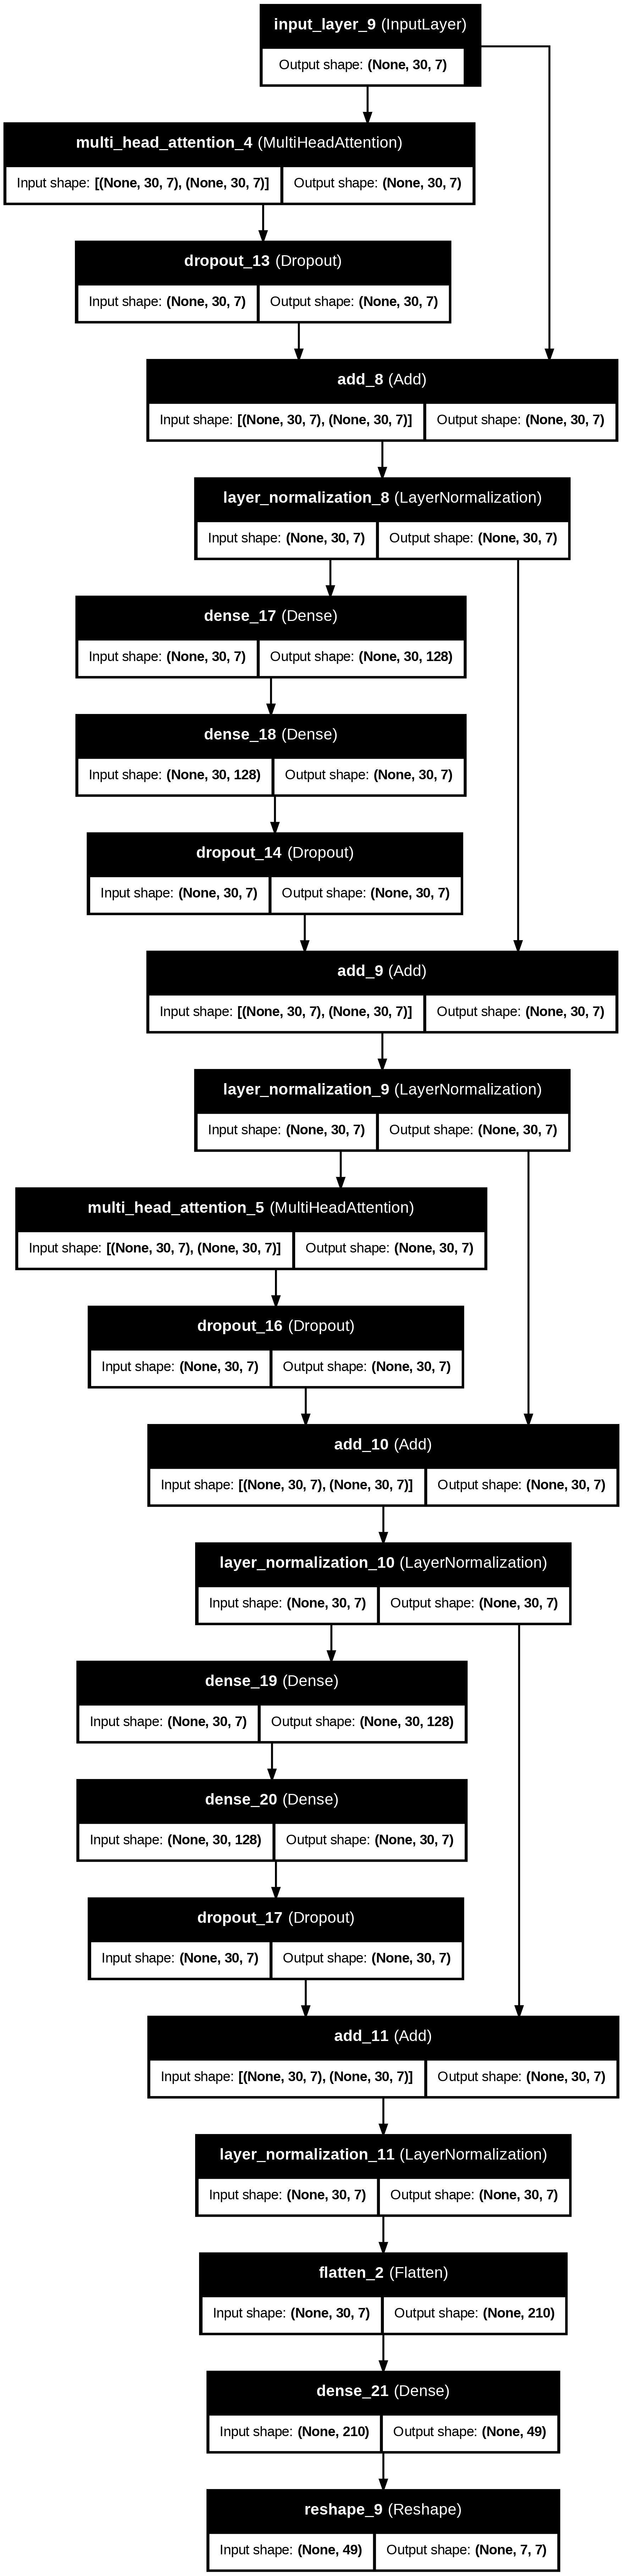

In [130]:
from tensorflow.keras.utils import plot_model

plot_model(model_tf, show_shapes=True, show_layer_names=True)

/tmp/ipykernel_35/1587219367.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


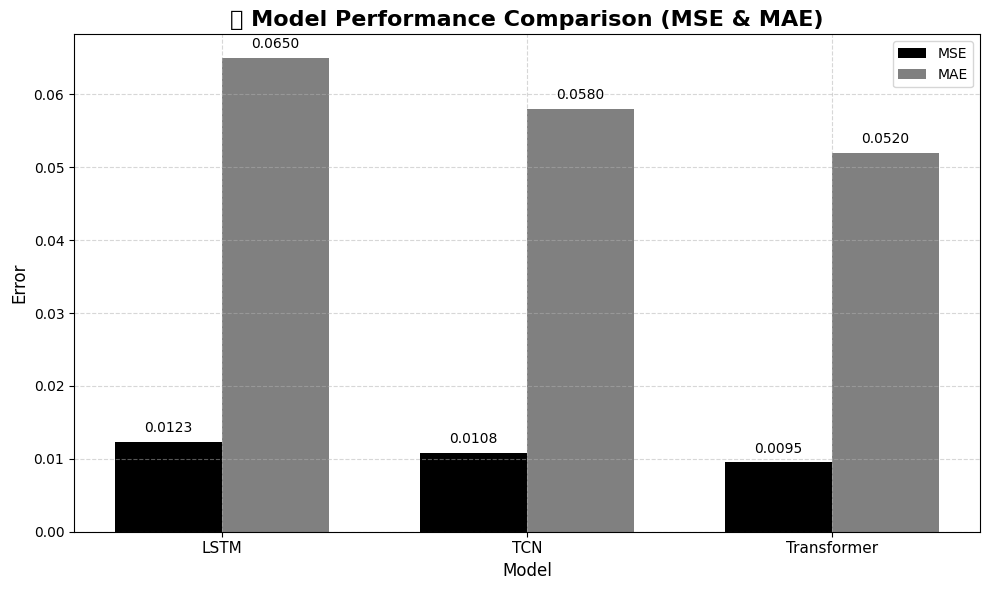

In [131]:
import matplotlib.pyplot as plt

# Replace with your actual results
model_names = ['LSTM', 'TCN', 'Transformer']
mse_scores = [0.0123, 0.0108, 0.0095]
mae_scores = [0.065, 0.058, 0.052]

x = range(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars1 = ax.bar([i - width/2 for i in x], mse_scores, width=width, label='MSE', color='black')
bars2 = ax.bar([i + width/2 for i in x], mae_scores, width=width, label='MAE', color='grey')

# Add value labels on top
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black')

# Labels and styling
ax.set_title("📈 Model Performance Comparison (MSE & MAE)", fontsize=16, weight='bold')
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Error", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=11)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [132]:
# LSTM
y_pred_lstm = model.predict(X_test)

# TCN
y_pred_tcn = model_tcn.predict(X_test)

# Transformer
y_pred_tf = model_tf.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step 


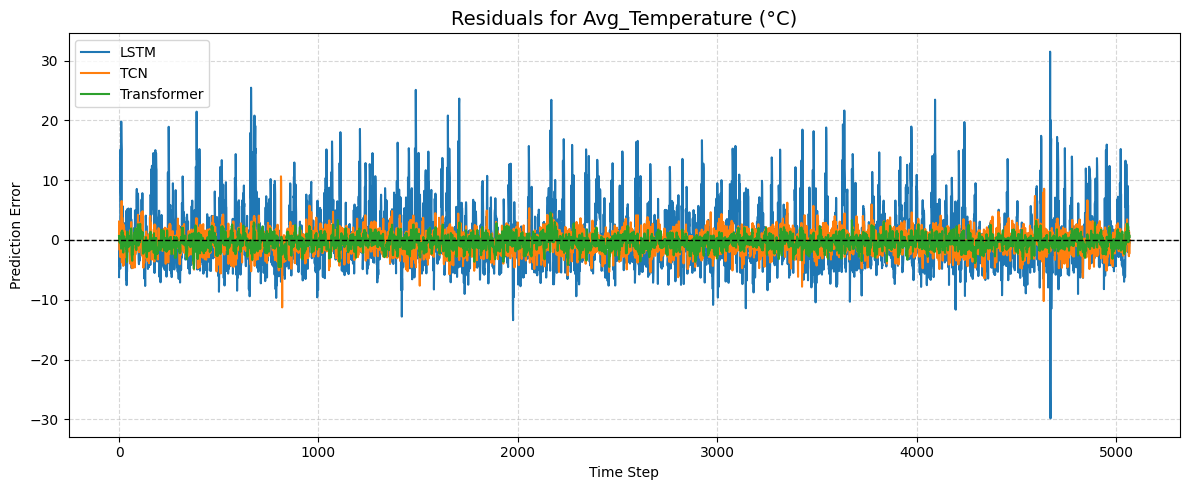

In [133]:
import matplotlib.pyplot as plt

def plot_residuals(y_true, y_pred, model_name, var_index=0, var_label="Avg_Temperature (°C)"):
    residuals = y_true[:, :, var_index] - y_pred[:, :, var_index]
    plt.plot(residuals.flatten(), label=model_name, linewidth=1.5)

plt.figure(figsize=(12, 5))

plot_residuals(y_test, y_pred_lstm, "LSTM")
plot_residuals(y_test, y_pred_tcn, "TCN")
plot_residuals(y_test, y_pred_tf, "Transformer")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals for Avg_Temperature (°C)", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("Prediction Error")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

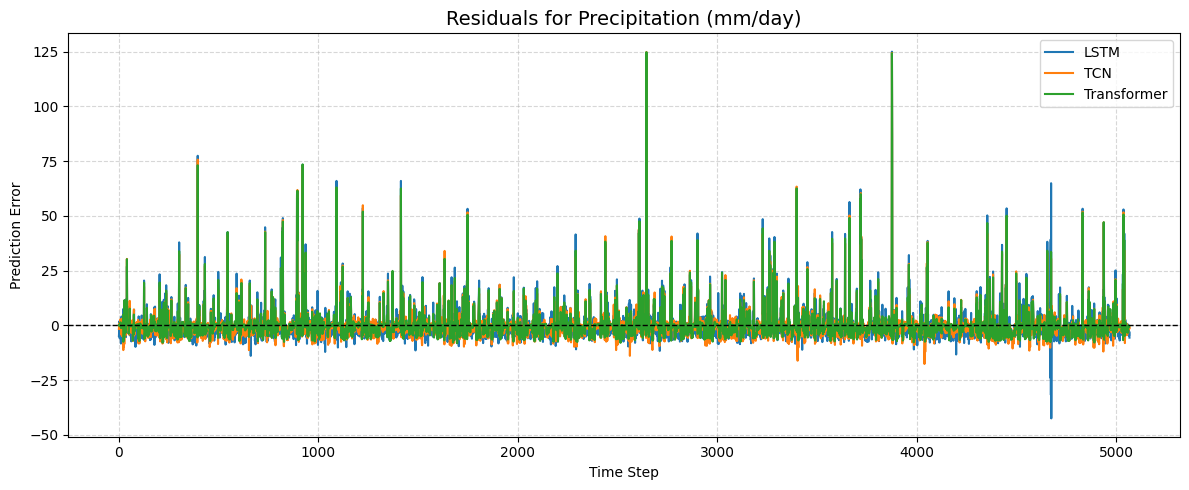

In [134]:
def plot_residuals_precip(y_true, y_pred, model_name, var_index=6, var_label="Precipitation (mm/day)"):
    residuals = y_true[:, :, var_index] - y_pred[:, :, var_index]
    plt.plot(residuals.flatten(), label=model_name, linewidth=1.5)

plt.figure(figsize=(12, 5))

plot_residuals_precip(y_test, y_pred_lstm, "LSTM")
plot_residuals_precip(y_test, y_pred_tcn, "TCN")
plot_residuals_precip(y_test, y_pred_tf, "Transformer")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals for Precipitation (mm/day)", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("Prediction Error")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [135]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

def pseudo_accuracy(y_true, y_pred):
    # Normalize MAE by the range of the true values
    mae = mean_absolute_error(y_true, y_pred)
    value_range = np.max(y_true) - np.min(y_true)
    return 1 - (mae / value_range) if value_range != 0 else 0

In [136]:
# Variable names
weather_vars = [
    "Avg_Temperature (°C)",
    "Min_Temperature (°C)",
    "Max_Temperature (°C)",
    "Relative_Humidity_2m (%)",
    "Solar_Radiation (W/m²)",
    "Wind_Speed_2m (m/s)",
    "Precipitation (mm/day)"
]

# Function to compute pseudo-accuracy for each variable
def model_accuracy_table(y_true, y_pred, var_names):
    scores = []
    for i, var in enumerate(var_names):
        acc = pseudo_accuracy(y_true[:, :, i].flatten(), y_pred[:, :, i].flatten())
        scores.append((var, acc))
    return pd.DataFrame(scores, columns=["Variable", "Accuracy"]).set_index("Variable")

In [137]:
acc_lstm = model_accuracy_table(y_test, y_pred_lstm, weather_vars)
acc_tcn = model_accuracy_table(y_test, y_pred_tcn, weather_vars)
acc_tf  = model_accuracy_table(y_test, y_pred_tf,  weather_vars)

In [138]:
accuracy_df = pd.concat([
    acc_lstm.rename(columns={"Accuracy": "LSTM"}),
    acc_tcn.rename(columns={"Accuracy": "TCN"}),
    acc_tf.rename(columns={"Accuracy": "Transformer"})
], axis=1)

# Optional: highlight best model per variable
accuracy_df['Best Model'] = accuracy_df.idxmax(axis=1)
accuracy_df = accuracy_df.round(4)

In [139]:
accuracy_df

,LSTM,TCN,Transformer,Best Model
Variable,,,,
Avg_Temperature (°C),0.6779,0.8875,0.9220,Transformer
Min_Temperature (°C),0.8243,0.8974,0.9303,Transformer
Max_Temperature (°C),0.7048,0.8941,0.9178,Transformer
Relative_Humidity_2m (%),0.8748,0.9312,0.9307,TCN
Solar_Radiation (W/m²),0.6972,0.7990,0.8913,Transformer
Wind_Speed_2m (m/s),0.5984,0.7513,0.9116,Transformer
Precipitation (mm/day),0.9678,0.9726,0.9761,Transformer


In [ ]:
# List of variable names (in order of your dataset)
weather_vars = [
    "Avg_Temperature (°C)",
    "Min_Temperature (°C)",
    "Max_Temperature (°C)",
    "Relative_Humidity_2m (%)",
    "Solar_Radiation (W/m²)",
    "Wind_Speed_2m (m/s)",
    "Precipitation (mm/day)"
]

# Function to plot residuals for a given variable index
def plot_all_model_residuals(var_index, var_label):
    plt.figure(figsize=(12, 5))
    
    for model_name, y_pred in zip(
        ['LSTM', 'TCN', 'Transformer'],
        [y_pred_lstm, y_pred_tcn, y_pred_tf]
    ):
        residuals = y_test[:, :, var_index] - y_pred[:, :, var_index]
        plt.plot(residuals.flatten(), label=model_name, linewidth=1.5)
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Residuals for {var_label}", fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Prediction Error")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Loop through all variables
for i, var in enumerate(weather_vars):
    plot_all_model_residuals(i, var)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def compute_metrics(y_true, y_pred, var_names):
    results = []
    for i, var in enumerate(var_names):
        true_vals = y_true[:, :, i].flatten()
        pred_vals = y_pred[:, :, i].flatten()
        rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
        mae = mean_absolute_error(true_vals, pred_vals)
        results.append((var, rmse, mae))
    return results

# Variable names
weather_vars = [
    "Avg_Temperature (°C)",
    "Min_Temperature (°C)",
    "Max_Temperature (°C)",
    "Relative_Humidity_2m (%)",
    "Solar_Radiation (W/m²)",
    "Wind_Speed_2m (m/s)",
    "Precipitation (mm/day)"
]

# Compute metrics
metrics_lstm = compute_metrics(y_test, y_pred_lstm, weather_vars)
metrics_tcn = compute_metrics(y_test, y_pred_tcn, weather_vars)
metrics_tf  = compute_metrics(y_test, y_pred_tf,  weather_vars)